In [1]:
import os, cv2, pickle, numpy as np
from tqdm import tqdm
from PIL import Image
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from transformers import AutoTokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_dir = "/kaggle/input/video-captioning-msvd/MSVD/videos"
caption_file = "/kaggle/input/video-captioning-msvd/MSVD/caption.txt"
resnet_weights_path = "/kaggle/input/aryan-resnet-w/resnet152-394f9c45.pth"
feature_dir = "/kaggle/working/msvd_features"
os.makedirs(feature_dir, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/aryan-auto-token/bert-tokenizer")

In [3]:
def load_msvd_captions(path: str) -> List[Tuple[str, str]]:
    with open(path, "r") as f:
        lines = f.readlines()
    return [line.strip().split(' ', 1) for line in lines]

msvd_data = load_msvd_captions(caption_file)

In [4]:
resnet = models.resnet152(weights=None)
resnet.load_state_dict(torch.load(resnet_weights_path, map_location=device))
resnet.eval()

model_feat_extractor = create_feature_extractor(resnet, return_nodes={"avgpool": "features"}).to(device)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

/tmp/ipykernel_31/737366955.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(resnet_weights_path, map_location=device))


In [5]:
class VideoFeatureExtractor:
    def __init__(self, model, transform, device, max_frames= 16):
        self.model = model
        self.transform = transform
        self.device = device
        self.max_frames = max_frames

    def extract(self, video_path: str) -> np.ndarray:
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret or len(frames) >= self.max_frames:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        if not frames:
            return np.zeros((self.max_frames, 2048))

        batch = torch.stack(frames).to(self.device)
        with torch.no_grad():
            feats = self.model(batch)["features"].squeeze(-1).squeeze(-1).cpu().numpy()
        return feats

In [6]:
extractor = VideoFeatureExtractor(model_feat_extractor, transform, device)

for video_id, _ in tqdm(msvd_data, desc="Extracting video features"):
    save_path = os.path.join(feature_dir, f"{video_id}.pkl")
    if os.path.exists(save_path): continue

    video_path = os.path.join(video_dir, f"{video_id}.avi")
    try:
        feats = extractor.extract(video_path)
        with open(save_path, "wb") as f:
            pickle.dump(feats, f)
    except Exception as e:
        print(f"Error processing {video_id}: {e}")

Extracting video features: 100%|██████████| 80827/80827 [06:39<00:00, 202.12it/s]


In [7]:
class MSVDFeatureDataset(Dataset):
    def __init__(self, data, feature_dir, tokenizer, max_len=30):
        self.data = data
        self.feature_dir = feature_dir
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_id, caption = self.data[idx]
        with open(os.path.join(self.feature_dir, f"{video_id}.pkl"), "rb") as f:
            feats = pickle.load(f)

        tokenized = self.tokenizer.encode(
            caption, padding='max_length', truncation=True,
            max_length=self.max_len, return_tensors="pt"
        ).squeeze()

        return torch.tensor(feats).float(), tokenized

train_dataset = MSVDFeatureDataset(msvd_data, feature_dir, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)

In [8]:
class LSTMDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.feat_proj = nn.Linear(input_dim, hidden_dim)

    def forward(self, feats, captions):
        feats = feats.mean(dim=1)
        feats = self.feat_proj(feats).unsqueeze(1)
        embeds = self.embedding(captions)
        x = torch.cat((feats, embeds), dim=1)
        out, _ = self.lstm(x)
        return self.fc(out)

In [9]:
model = LSTMDecoder(input_dim=2048, hidden_dim=512, vocab_size=tokenizer.vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_31/3076183394.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [10]:
#

In [11]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
bleu_scores = []




num_epochs = 10

def validate(model, val_loader, tokenizer, criterion):
    model.eval()
    total_val_loss = 0
    bleu_total = 0
    smooth_fn = SmoothingFunction().method1

    with torch.no_grad():
        for feats, captions in val_loader:
            feats = feats.to(device)
            captions = captions.to(device)

            outputs = model(feats, captions[:, :-1])
            outputs = outputs[:, 1:]
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
            total_val_loss += loss.item()

            # BLEU Score
            preds = torch.argmax(outputs, dim=-1)
            for pred, target in zip(preds, captions[:, 1:]):
                pred_tokens = tokenizer.decode(pred, skip_special_tokens=True).split()
                target_tokens = tokenizer.decode(target, skip_special_tokens=True).split()
                bleu_total += sentence_bleu([target_tokens], pred_tokens, smoothing_function=smooth_fn)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_bleu = bleu_total / len(val_loader.dataset)
    return avg_val_loss, avg_bleu


In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for feats, captions in loop:
        feats = feats.to(device, non_blocking=True)
        captions = captions.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(feats, captions[:, :-1])
            outputs = outputs[:, 1:]
            target = captions[:, 1:]

            loss = criterion(outputs.reshape(-1, outputs.size(-1)), target.reshape(-1))

            preds = outputs.argmax(dim=-1)
            mask = target != tokenizer.pad_token_id
            correct = (preds == target) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        avg_loss = total_loss / (loop.n + 1)
        accuracy = total_correct / total_tokens if total_tokens != 0 else 0
        loop.set_postfix(loss=avg_loss, accuracy=accuracy * 100)

    train_losses.append(avg_loss)
    acc = accuracy * 100
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")

    # Validation
    val_loss, bleu = validate(model, train_loader, tokenizer, criterion)  # replace with val_loader if you have a val split
    val_losses.append(val_loss)
    bleu_scores.append(bleu)
    print(f"Validation Loss: {val_loss:.4f} | BLEU: {bleu:.4f}")


Epoch 1:   0%|          | 0/2526 [00:00<?, ?it/s]/tmp/ipykernel_31/3932389098.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 2526/2526 [01:13<00:00, 34.29it/s, accuracy=36.5, loss=4.19]


Epoch 1 — Loss: 4.1901 | Accuracy: 36.55%
Validation Loss: 3.5114 | BLEU: 0.1050


Epoch 2: 100%|██████████| 2526/2526 [01:12<00:00, 34.71it/s, accuracy=43.9, loss=3.26]

Epoch 2 — Loss: 3.2554 | Accuracy: 43.87%


Validation Loss: 2.9805 | BLEU: 0.0518


Epoch 3: 100%|██████████| 2526/2526 [01:13<00:00, 34.58it/s, accuracy=48.1, loss=2.85]

Epoch 3 — Loss: 2.8488 | Accuracy: 48.07%


Validation Loss: 2.6570 | BLEU: 0.0355


Epoch 4: 100%|██████████| 2526/2526 [01:12<00:00, 34.71it/s, accuracy=51.4, loss=2.57]

Epoch 4 — Loss: 2.5713 | Accuracy: 51.42%


Validation Loss: 2.4124 | BLEU: 0.0419


Epoch 5: 100%|██████████| 2526/2526 [01:12<00:00, 34.71it/s, accuracy=54.1, loss=2.36]

Epoch 5 — Loss: 2.3584 | Accuracy: 54.10%


Validation Loss: 2.2206 | BLEU: 0.0463


Epoch 6: 100%|██████████| 2526/2526 [01:12<00:00, 34.72it/s, accuracy=56.3, loss=2.19]

Epoch 6 — Loss: 2.1879 | Accuracy: 56.29%


Validation Loss: 2.0652 | BLEU: 0.0511


Epoch 7: 100%|██████████| 2526/2526 [01:12<00:00, 34.76it/s, accuracy=58, loss=2.05]  

Epoch 7 — Loss: 2.0505 | Accuracy: 58.05%


Validation Loss: 1.9404 | BLEU: 0.0516


Epoch 8: 100%|██████████| 2526/2526 [01:12<00:00, 34.73it/s, accuracy=59.4, loss=1.94]

Epoch 8 — Loss: 1.9360 | Accuracy: 59.44%


Validation Loss: 1.8361 | BLEU: 0.0569


Epoch 9: 100%|██████████| 2526/2526 [01:12<00:00, 34.74it/s, accuracy=60.7, loss=1.84]

Epoch 9 — Loss: 1.8394 | Accuracy: 60.66%


Validation Loss: 1.7490 | BLEU: 0.0584


Epoch 10: 100%|██████████| 2526/2526 [01:12<00:00, 34.74it/s, accuracy=61.7, loss=1.75]

Epoch 10 — Loss: 1.7547 | Accuracy: 61.74%


Validation Loss: 1.6627 | BLEU: 0.0608


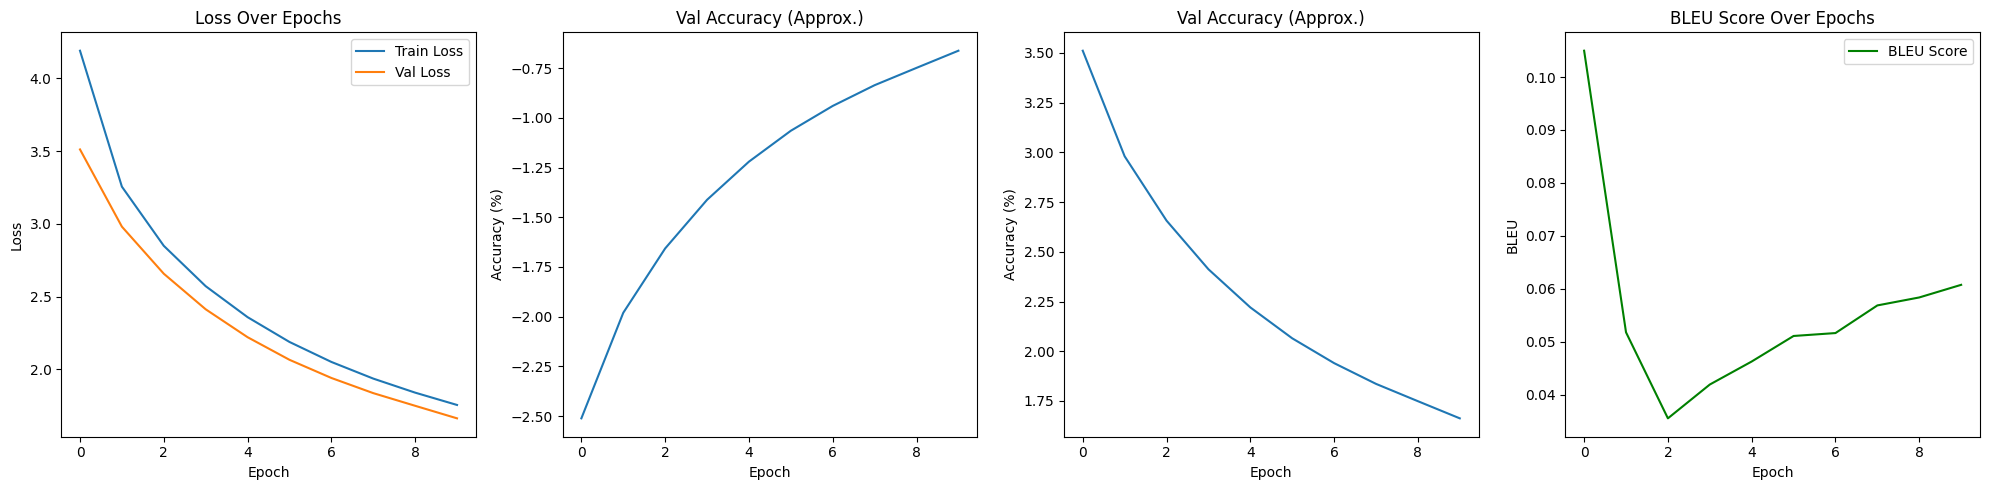

In [13]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 4, 2)
plt.plot([(1-l) for l in val_losses], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Val Accuracy (Approx.)")


# Accuracy plot
plt.subplot(1, 4, 3)
plt.plot([ (l) for l in val_losses], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Val Accuracy (Approx.)")

# BLEU plot
plt.subplot(1, 4, 4)
plt.plot(bleu_scores, label="BLEU Score", color='green')
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.title("BLEU Score Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()





# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////






# Save model after training
save_path = "video_caption_model.pth"

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'loss': total_loss,
}, save_path)

In [14]:
# Load model before inference or to resume training
checkpoint = torch.load("/kaggle/input/aryan-vdo-model-1/video_caption_model.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])

model.eval()  # Use .train() if you're resuming training

/tmp/ipykernel_31/770839193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/aryan-vdo-model-1/video_caption_model.pth", map_locati

LSTMDecoder(
  (embedding): Embedding(30522, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=30522, bias=True)
  (feat_proj): Linear(in_features=2048, out_features=512, bias=True)
)

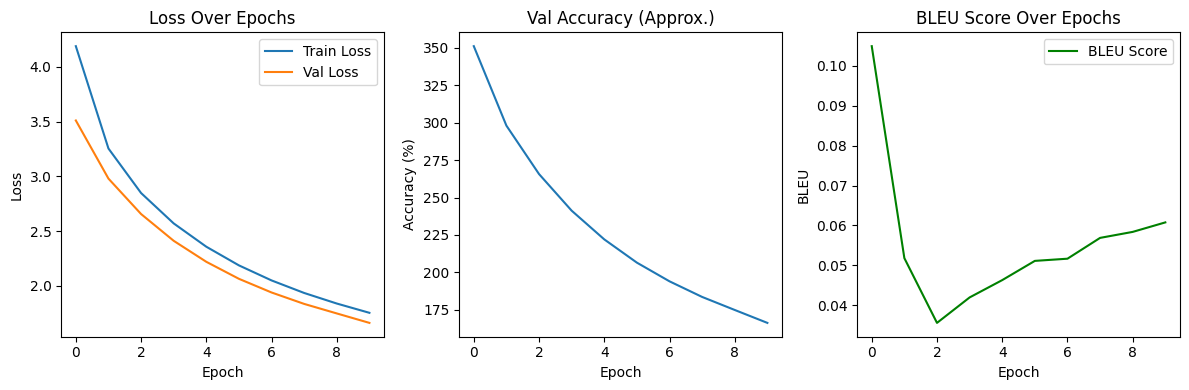

In [15]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot([100 * (l) for l in val_losses], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Val Accuracy (Approx.)")

# BLEU plot
plt.subplot(1, 3, 3)
plt.plot(bleu_scores, label="BLEU Score", color='green')
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.title("BLEU Score Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()





# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////






# Save model after training
save_path = "video_caption_model.pth"

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'loss': total_loss,
}, save_path)

In [16]:
def generate_caption(feat_path, model, tokenizer, max_len=30):
    model.eval()
    with open(feat_path, "rb") as f:
        feats = pickle.load(f)
    feats = torch.tensor(feats).unsqueeze(0).to(device)

    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    generated = []

    for _ in range(max_len):
        with torch.no_grad():
            out = model(feats, input_ids)
        next_token = out[0, -1].argmax(dim=-1).unsqueeze(0)
        if next_token.item() == tokenizer.sep_token_id:
            break
        generated.append(next_token.item())
        input_ids = torch.cat((input_ids, next_token.unsqueeze(0)), dim=1)

    return tokenizer.decode(generated, skip_special_tokens=True)

# Example
feat_file = os.path.join(feature_dir, "-7KMZQEsJW4_205_208.pkl")
print("Generated Caption:", generate_caption(feat_file, model, tokenizer))

Generated Caption: a man is holding two sunflowers


repeat

In [17]:
import torch
from torchvision import transforms
from torchvision.models import resnet152
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet152 from local weights
weights_path = "/kaggle/input/aryan-resnet-w/resnet152-394f9c45.pth"
resnet = resnet152(weights=None)
resnet.load_state_dict(torch.load(weights_path, map_location=device))
resnet.eval()

# Extract features from 'avgpool' layer
resnet_extractor = create_feature_extractor(resnet, return_nodes={"avgpool": "features"}).to(device)

# Image transform
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

/tmp/ipykernel_31/1861669993.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(weights_path, map_location=device))


In [18]:
class VideoFeatureExtractor1:
    def __init__(self, model, transform, device, max_frames=16):
        self.model = model
        self.transform = transform
        self.device = device
        self.max_frames = max_frames

    def extract(self, video_path: str) -> np.ndarray:
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret or len(frames) >= self.max_frames:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        if not frames:
            return np.zeros((self.max_frames, 2048))

        batch = torch.stack(frames).to(self.device)
        with torch.no_grad():
            feats = self.model(batch)["features"].squeeze(-1).squeeze(-1).cpu().numpy()
        return feats

    def extract_from_frame(self, frame: np.ndarray) -> torch.Tensor:
        """
        Extract features from a single RGB frame.
        """
        frame = self.transform(frame)
        frame = frame.unsqueeze(0).to(self.device)  # shape: [1, 3, 224, 224]
        with torch.no_grad():
            feat = self.model(frame)["features"].squeeze(-1).squeeze(-1)
        return feat.squeeze(0)  # shape: [2048]


In [19]:
feature_extractor1 = VideoFeatureExtractor1(
    model=resnet_extractor,
    transform=image_transform,
    device=device,
    max_frames=6  # or 60 for 10-second full clip
)


In [20]:
import time

def describe_video_with_sliding_window_optimized(video_path, model, tokenizer, feature_extractor, window_sec=0.5, max_len=30):
    cap = cv2.VideoCapture(video_path)

    # Get the FPS and total frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = int(total_frames / fps)

    window_size = int(fps * window_sec)
    descriptions = []
    
    # Start timer to track performance
    start_time = time.time()

    for sec in range(duration):
        start_frame = max(0, int((sec - window_sec) * fps))
        end_frame = min(total_frames, int((sec + window_sec) * fps))

        frames = []
        # Batch read frames for window
        for idx in range(start_frame, end_frame, 5):  # Process every 5th frame to reduce load
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                continue
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            transformed = feature_extractor.transform(frame_rgb)
            frames.append(transformed)

        if not frames:
            continue

        batch = torch.stack(frames).to(device)
        with torch.no_grad():
            feats = feature_extractor.model(batch)["features"].squeeze(-1).squeeze(-1)
        pooled_feat = feats.mean(dim=0).unsqueeze(0).unsqueeze(0)

        # Generate caption
        input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
        generated = []

        for _ in range(max_len):
            with torch.no_grad():
                out = model(pooled_feat, input_ids)
            next_token = out[0, -1].argmax(dim=-1).unsqueeze(0)
            if next_token.item() == tokenizer.sep_token_id:
                break
            generated.append(next_token.item())
            input_ids = torch.cat((input_ids, next_token.unsqueeze(0)), dim=1)

        caption = tokenizer.decode(generated, skip_special_tokens=True)
        descriptions.append((sec, caption))

    cap.release()

    # Print the total time taken
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    return descriptions


In [21]:
video_path = "/kaggle/input/video-captioning-msvd/MSVD/play.avi"
descriptions = describe_video_with_sliding_window_optimized(video_path, model, tokenizer, feature_extractor1)

for second, caption in descriptions:
    print(f"Second {second:02d}: {caption}")

Time taken: 2.13 seconds
Second 00: a person is pouring a water and rice into a bowl
Second 01: a person is pouring a bowl of rice into a pot
Second 02: a person is pouring a milk into a bowl of rice
Second 03: a person is pouring a milk in the pot
Second 04: a person is pouring a bowl of milk into a pot of rice


**code for overlay**

In [27]:
import cv2
import numpy as np
import time

def overlay_captions_on_video_optimized(video_path, model, tokenizer, feature_extractor, fps=6, window_sec=1, output_path="unseen_video.mp4"):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    real_fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration_sec = int(total_frames // real_fps)

    # Ensure video duration and caption generation is correct
    if duration_sec > total_frames / real_fps:
        duration_sec = int(total_frames / real_fps)

    # Use mp4 format and MP4V codec
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, real_fps, (width, height))

    # Generate second-wise captions with optimized sliding window approach
    descriptions = describe_video_with_sliding_window_optimized(video_path, model, tokenizer, feature_extractor, window_sec=window_sec, max_len=30)

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_count = 0
    current_caption = ""
    current_second = 0

    # Start timer for performance
    start_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Calculate current second based on frame count and fps
        frame_second = int(frame_count // real_fps)

        # Assign the caption for the current second, ensure consistent captioning for each second
        if frame_second < len(descriptions) and frame_second != current_second:
            current_caption = descriptions[frame_second][1]
            current_second = frame_second

        # Overlay text on the video frame
        cv2.putText(
            frame,
            f"{frame_second}s: {current_caption}",
            (20, height - 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA
        )

        # Write frame with overlayed caption
        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()

    # Print the total time taken to generate the video
    end_time = time.time()
    print(f"✔️ Captioned MP4 video saved to: {output_path}")
    print(f"Time taken to process video: {end_time - start_time:.2f} seconds")



In [28]:
# video_path = "/kaggle/input/testing-data-aryan/test_1.mp4"
# overlay_captions_on_video_optimized(video_path, model, tokenizer, feature_extractor1)

In [29]:
# video_path = "/kaggle/input/testing-data-aryan/test_2.mp4"
# overlay_captions_on_video_optimized(video_path, model, tokenizer, feature_extractor1)

In [25]:
video_path = "/kaggle/input/testing-data-aryan/test_2.mp4"
overlay_captions_on_video_optimized(video_path, model, tokenizer, feature_extractor1)

Time taken: 63.84 seconds
✔️ Captioned MP4 video saved to: test_3_output.mp4
Time taken to process video: 5.97 seconds


try

In [30]:
video_path = "/kaggle/input/unseen-video/videoplayback.mp4"
overlay_captions_on_video_optimized(video_path, model, tokenizer, feature_extractor1)

Time taken: 49.50 seconds
✔️ Captioned MP4 video saved to: unseen_video.mp4
Time taken to process video: 4.78 seconds
